<a href="https://colab.research.google.com/github/DonnaVakalis/forecasting-MRT-gap/blob/main/models/XGBoost2__AirTemp_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with XGBoost model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [1]:
# Install XGBoost
# ! pip install xgboost # this gives version 0.90
! pip install xgboost==1.4.2 # as of Sept 2021 this is most recent stable release

# import all the usual suspects :)
import os
from google.colab import drive
import pickle
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt

# Sci-kit learn packages for normalizing data and post-processing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, matthews_corrcoef, r2_score, accuracy_score
 
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# boosting libraries from XGBoost
import xgboost as xgb

print("XGBoost version:", xgb.__version__)

     |████████████████████████████████| 166.7 MB 5.8 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
XGBoost version: 1.4.2


# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

## Mount drive with data

In [2]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

Mounted at /content/gdrive


## Upload Data and Restrict to Summer/Non-smoky Times

We want temperature data from all three summers, minus the smoky periods (smoke-affected days = when recorded incidences of regional forest fires)

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

In [3]:
# 2015

# get training set from another year (so complete for 2015)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2015-05-23') #*keep last week of May (if available) for lag time
remove_after = pd.to_datetime('2015-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2015-07-01')
end_smoke = pd.to_datetime('2015-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2015 outdoor temps (x variable)
df_2015_X = df_3 



# 2016 

# get training set from another year (so complete for 2016)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2016-05-23') #*keep last week of May if available  
remove_after = pd.to_datetime('2016-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# save 2016 outdoor temps (x variable)
df_2016_X = df_2



# 2017

# get training set from another year (so complete for 2017)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2017-05-23') #*keep last week of May if available  
remove_after = pd.to_datetime('2017-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2017-08-01')
end_smoke = pd.to_datetime('2017-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2017 outdoor temps (x variable)
df_2017_X = df_3

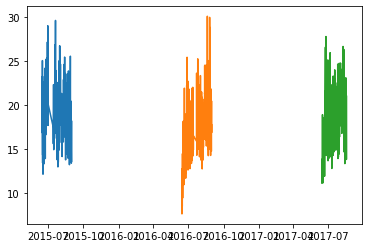

In [4]:
# plot all outdoor temperatures in cleaned dataset
plt.plot(df_2015_X.index, df_2015_X.temp, df_2016_X.index, df_2016_X.temp, df_2017_X.index, df_2017_X.temp) 
plt.show() 

# SELECT FEATURES

In [13]:
# keep indoor air temp and relative humidity
df_2015_X = df_2015_X[['temp','last_temp_2','last_temp_4','hum_ratio']]
df_2016_X = df_2016_X[['temp','last_temp_2','last_temp_4','hum_ratio']]
df_2017_X = df_2017_X[['temp','last_temp_2','last_temp_4','hum_ratio']]

## Add feature for previous temperatures

In [14]:
ls_X = [df_2015_X, df_2016_X, df_2017_X] 

# Add rolling AVERAGE air temp of the PAST 48 hours
def addAverage(df):
    df['temp_ave_48hr'] = df['temp'].rolling(48, min_periods=1).mean() 
    return df 
ls_X2  = [addAverage(df) for df in ls_X]
 

# Add the rolling MAX air temp of the last 24 hours
def addMax(df):
    df['temp_max_24hr'] = df['temp'].rolling(24).max()
    return df 
ls_X3  = [addMax(df) for df in ls_X2]


# Add the rolling MIN air temp of the last 24 hours
def addMin(df):
    df['temp_min_24hr'] = df['temp'].rolling(24).min()
    return df 
ls_X4  = [addMin(df) for df in ls_X3]




ls_X = ls_X4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Concatenate 2015, 2016, 2017 into one dataframe

In [15]:
# save a single dataset with all years
df_all_X = pd.concat(ls_X)

## Add feature for time of day 

This step adds a variable to help the model understand the cyclicity of the 24 hours cycle
It borrows from the tutorial provided here: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

We want the machine to know that hours 23 and 0 are closer to each other than hours 0 and 4. We know that the period of the cycle is 24 hours. We can use the cos(x) and sin(x) functions. The x in the functions is the hour of the day.

In [16]:
# Extract the hour of day
df_all_X["hour"] = df_all_X.index.hour

# Transform to the cyclical daily feature 
df_all_X["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]
df_all_X["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]

# Drop hour of the day as it's own feature
df_all_X.drop('hour', axis=1, inplace=True)

## Get outcome variable of interest

## Get indoor air temperatures (for same time spans as outdoor features)

In [17]:
#Get raw data of indoor air temps (what we want to predict) 

df1 = pickle.load(open(DATA_PATH +'/trainY_2015.pkl','rb'))
df2 = pickle.load(open(DATA_PATH +'/trainY_2016.pkl','rb'))
df3 = pickle.load(open(DATA_PATH +'/trainY_2017.pkl','rb'))


# Put in all in one place 
ls_Y = [df1, df2, df3]  
df_Y = pd.concat(ls_Y)

# Drop duplicated date-times
df_Y = df_Y[~df_Y.index.duplicated(keep='first')]

# Drop date-times not in X set
df_Y = df_Y[df_Y.index.isin(df_all_X.index)]

# Name column Air Temp Indoors (to distinguish from outdoor or operative indoor)
df_Y = df_Y.to_frame('air_tmp_ind')
df_Y.sort_index(inplace=True)

## Finalize Features and Prediction Target, and Plot some X versus and Y 

In [18]:
# Store the MRT variable as the targetted outcome variable
df_Y_trgt = df_Y[['air_tmp_ind']]
print("predicting: ",df_Y_trgt.columns[0])

# Time stamped features dataframe: df_all_X
print("num of features: ", df_all_X.shape[1])
print("features: ", df_all_X.columns.values)

print("num time points :", df_all_X.shape[0])

predicting:  air_tmp_ind
num of features:  9
features:  ['temp' 'last_temp_2' 'last_temp_4' 'hum_ratio' 'temp_ave_48hr'
 'temp_max_24hr' 'temp_min_24hr' 'day_cos' 'day_sin']
num time points : 4632


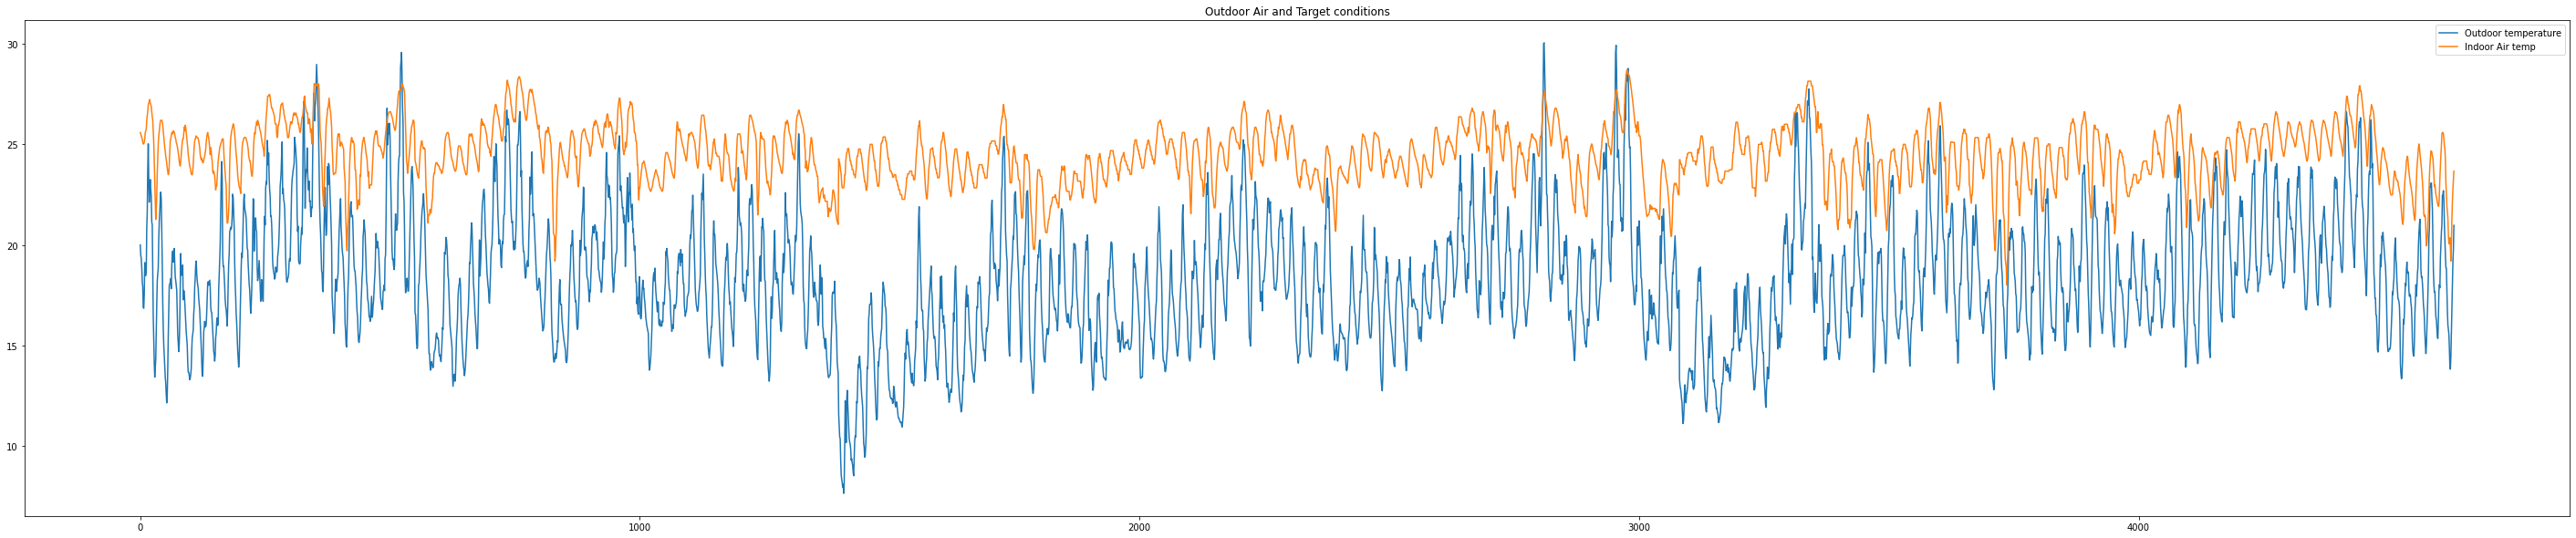

In [19]:
# Visualize the Temperatures (air, comfortable target, required MRT to reach comfortable)
plt.figure(figsize=(50,10))
x_ax = range(len(df_Y_trgt.index))
#plt.plot(x_ax,df_Y_scratch.air_tmp_ind, label="air temperature")
#plt.plot(x_ax, df_Y_scratch.op_tmp_comfy, label="comfortable operative temperature")
plt.plot(x_ax, df_all_X.temp, label="Outdoor temperature")
plt.plot(x_ax, df_Y_trgt.air_tmp_ind, label="Indoor Air temp")

plt.title("Outdoor Air and Target conditions")

plt.legend()
plt.show()

## Extra pre-training step: keep only times of day where you care about adding MRT (i.e., during building operating hours) 

The idea is that we want to optimize the model for predictions during this time of day when we will actually be using the predictions... even if it is worse at night or on average. Recall that in setting up the features, we already recorded the lag variables that contain information about nightime lows and previous hours. These can still inform the prediction of conditions during daytime hours.

In [38]:
# function for filtering out after-hours (keep 8-6? keep weekdays only?)

def remove_unoccupied_times(df_allTimes):

    day = df_allTimes.index.dayofweek # Saturday day_of_week = 5 and Sunday_of_week = 6 
    time = df_allTimes.index.hour
    return df_allTimes.iloc[((day != 5) & (day != 6)) & ((time >= 9) & (time <= 17))]
     

# filter out irrelevant hours from features set X
df_X_occHrs = remove_unoccupied_times(df_all_X.copy())
 
#filter out irrelevant hours from target y
df_y_occHrs = remove_unoccupied_times(df_Y_trgt.copy())

# DEFINE and RUN XGBoost MODEL

## Split training and test sets, and save date-time stamps as separate array

In [39]:
x = df_X_occHrs.copy().to_numpy()

# need to reshape Y which contains 1 features (currently it's 0) 
y = df_y_occHrs.copy().to_numpy().reshape(-1,1)

# create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)
t = df_X_occHrs.index.copy()

# NB split should not be an unordered... (shuffle=False)
x_train, testX, y_train, testY, time_train, testTime = train_test_split(x, y, t, shuffle = False, test_size= 0.15)

# check
print("time stamps for train and test sets:", time_train.shape, testTime.shape)
print("train_dim Xs and Y:", x_train.shape, y_train.shape)
print("test_dim Xs and Y", testX.shape, testY.shape)

time stamps for train and test sets: (1060,) (188,)
train_dim Xs and Y: (1060, 9) (1060, 1)
test_dim Xs and Y (188, 9) (188, 1)


## Define the XGBoost objective function and search hyper-parameter space

### Set up parameters (with aim of using HyperOpt to optimize)

 

In [40]:
# Borrowed instructions from here: https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9
# Training data: x_train and y_train 
# Testing data: testX and testY 

# Initialize fixed values (won't be tuned)
N_EST = 1000 
ETA = 0.05  # learning rate range : [0,1] Typical final values : 0.01-0.2
SUB = 0.85 # Typical values: 0.5-1 ... Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
 
# Initialize required range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1), #L2 regularization term on weights (analogous to Ridge regression)
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
        
    }
    
# Define regression objective function: 
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = N_EST, 
                           eta =  ETA,
                           subsample = SUB,
                           max_depth = int(space['max_depth']), 
                           gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']),
                           reg_lambda = space['reg_lambda'],
                           colsample_bytree=space['colsample_bytree'],
                           min_child_weight=space['min_child_weight'])
    
    evaluation = [( x_train, y_train), ( testX, testY)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse", # objective [default=reg:squarederror]
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(testX)
    mse= mean_squared_error(testY, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

In [41]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:
0.8593436584074685
SCORE:
0.9587587112111029
SCORE:
0.6573289572682867
SCORE:
0.6882839389627002
SCORE:
0.6144433883542147
SCORE:
0.9381087466934191
SCORE:
0.8388134906085307
SCORE:
0.9276642079100648
SCORE:
0.6373950275236283
SCORE:
0.7909155215484627
SCORE:
0.6934653773072738
SCORE:
0.8278653011008953
SCORE:
0.8977740418270655
SCORE:
0.9316406793135389
SCORE:
0.5911855447212252
SCORE:
0.8464372667597171
SCORE:
0.927908645380138
SCORE:
0.8442932266990728
SCORE:
0.9222659192958041
SCORE:
0.6587706829760906
SCORE:
0.6941969197186473
SCORE:
0.7008432489416324
SCORE:
0.5998514902782147
SCORE:
0.5980584993095063
SCORE:
0.5741333054505019
SCORE:
0.6476485729655672
SCORE:
0.7240733227995021
SCORE:
0.6492406138800171
SCORE:
0.5356071879433215
SCORE:
0.7382129362430124
SCORE:
0.7112376808656411
SCORE:
0.6281456680781835
SCORE:
0.5508156620648613
SCORE:
0.6574350577504097
SCORE:
0.6561324215488985
SCORE:
0.6420980519030172
SCORE:
0.7331646336495256
SCORE:
0.750520352856889
SCORE:
0.64325

In [42]:
best

{'colsample_bytree': 0.8751229921506842,
 'gamma': 1.2889040112298917,
 'max_depth': 5.0,
 'min_child_weight': 5.0,
 'reg_alpha': 40.0,
 'reg_lambda': 0.7067256793240159}

## Fit the tuned model with the training data

Re-train the model algorithm using the best parameters obtained using hyperopt and evaluate it's predictions against the test set 

In [43]:
# create an xgboost regression model with the best hyperparameters (based on tuning above)
model = xgb.XGBRegressor(n_estimators = N_EST, 
                           eta =  ETA,
                           subsample = SUB,
                           max_depth = int(best['max_depth']), 
                           gamma = best['gamma'],
                           reg_alpha = int(best['reg_alpha']),
                           reg_lambda = best['reg_lambda'],
                           colsample_bytree= best['colsample_bytree'],
                           min_child_weight= best['min_child_weight'])
    
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8751229921506842, eta=0.05,
             gamma=1.2889040112298917, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0500000007,
             max_delta_step=0, max_depth=5, min_child_weight=5.0, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=2,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=40, reg_lambda=0.7067256793240159, scale_pos_weight=1,
             subsample=0.85, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Use Model to Predict values (and compare to test set)

## MSE and Visually examine predicted indoor air temp against test set 

MSE: 0.51
RMSE: 0.72


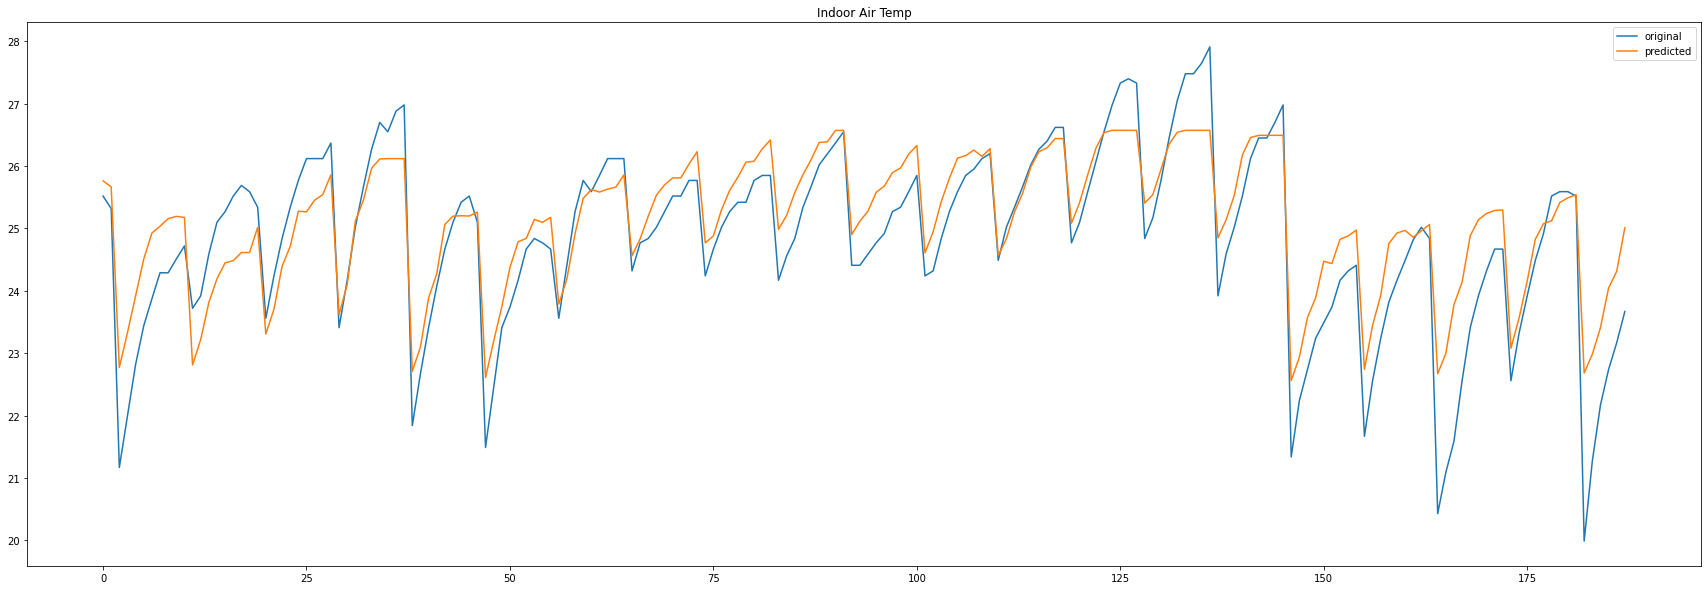

In [44]:
# Prediction
y_pred = model.predict(testX)

# Calculate Mean Squared Error
mse = mean_squared_error(testY, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# Visualize Predictions versus Test Set
plt.figure(figsize=(30,10))
x_ax = range(len(testY))
plt.plot(x_ax, testY, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Indoor Air Temp")

plt.legend()
plt.show()

#  USE PREDICTION (OR KNOWN INDOOR TEMP) ALONG WITH OUTDOOR TEMP TO CALCULATE DESIRED LOCAL MRT

###  Finding the (hourly) 'comfortable' operative temperature based on average outdoor air temperatures  

The adaptive comfort model's stipulated 'comfortable oeprative temperature' which is defined as a function of the average outdoor air temperature.

Tcomf = 0.31*[Ta,out] + 17.8

where: Tcomf = indoor comfortable temperature
Ta,out = mean outdoor air temperature*

*mean outdoor temperature as the input variable for the adaptive model. It is based on the arithmetic average of the mean daily outdoor temperatures over no fewer than 7 and no more than 30 sequential days prior. We will use 7.


sources:
ANSI/ASHRAE Standard 55-2017, Thermal Environmental Conditions for Human Occupancy. de Dear, R., & Brager, G. S. (2002). Thermal comfort in naturally ventilated buildings: revisions to ASHRAE Standard 55. Energy and Buildings, 34, 549-561.

In [45]:
def get_comfy_opTemperature (outdoor_air):

    # Calculate average of previous week's outdoor air temp (for calculating comfortable op temp)
    out_7dayAverage = outdoor_air.rolling(168, min_periods=72).mean() 

    # Calculate adaptive model comfort temp
    return 0.31*out_7dayAverage +17.8

### Use comfy threshold to find the (hourly) local MRT necessary given background indoor temps

The desired 'outcome' is whether the current hour is 'comfortable', based on comparing the indoor air temperature and the adaptive comfort model's stipulated 'comfortable oeprative temperature' (see previous block). 

GAP = op_temp_comfy - op_temp

where

op_temp = 0.5*(air_temp + MRT)

i.e., indoor operative temperature is an average of air temperature and mean radiant temperature, MRT

If the GAP is 0, then:

op_temp_comfy == op_temp

op_temp_comfy == 0.5*(air_temp + MRT)

And re-written to find what the gap is in terms of MRT:

MRT = 2*op_temp_comfy - air_temp

In [46]:
def get_required_MRT(comfy_operativeTemp,indoor_airTemp): 
    # this is the gap between indoor AIR temp and desired indoor OPERATIVE temp
    return 2*comfy_operativeTemp - indoor_airTemp

## Using above functions, calculate the MRT 
1. using each of the whole data, and then 
2. for the time period of just test set (i.e., known vs. prediction-based indoor temp)

### 1. MRT based on the entire input set (ie. known outdoor and known indoor)

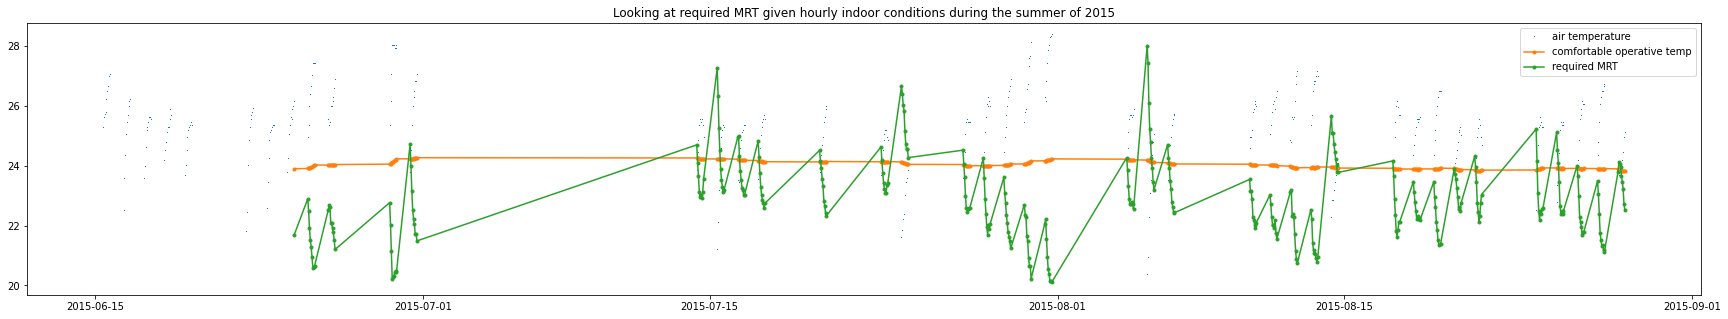

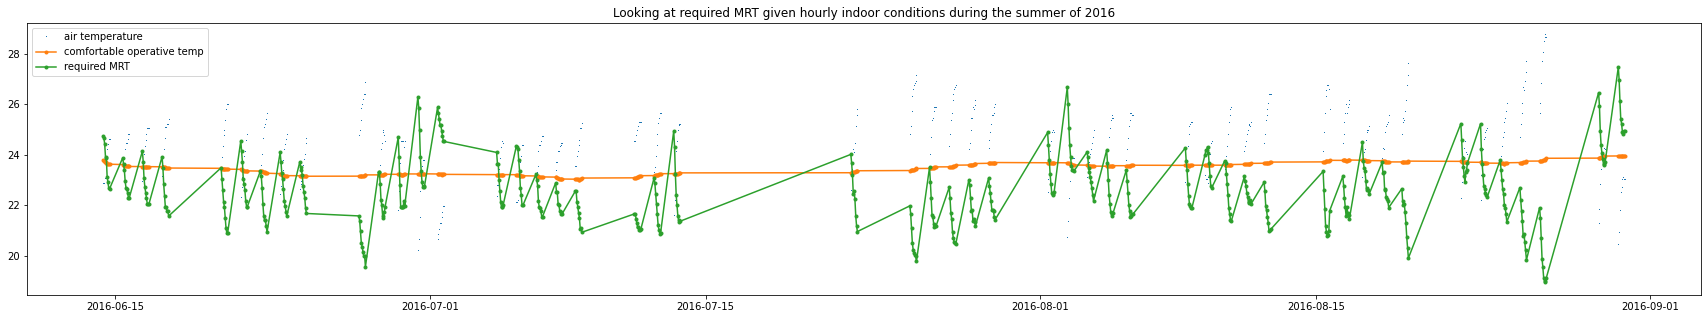

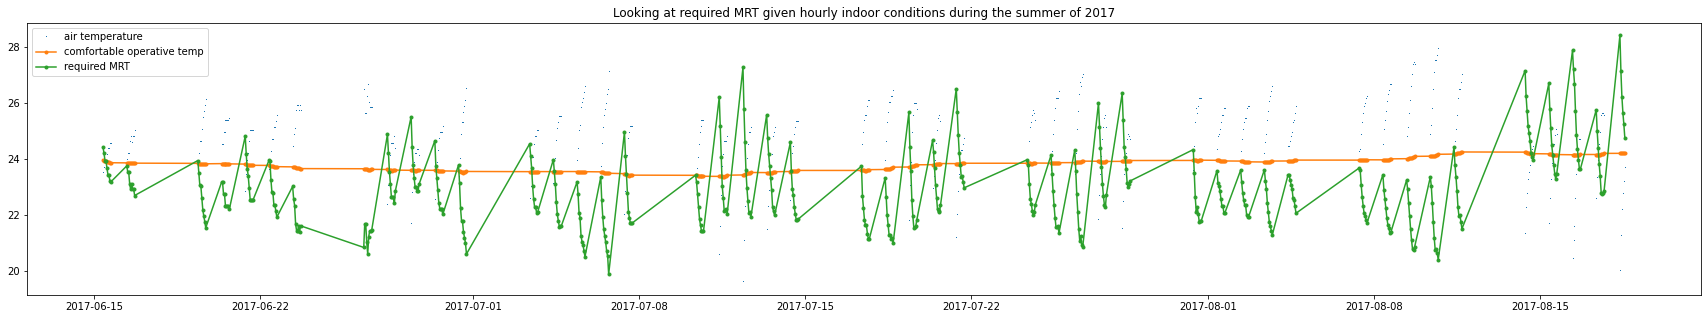

In [47]:
# We don't need all the features from the X set, just the outdoor temp! 
out_air = pd.Series(x[:,0]) # # x_train[:,0] or testX[:,0] are the split of df_all_X['temp'] 

# Get the target variable (indoor temp) either 'real' or predicted
ind_air = pd.Series(y[:,0]) # change y to test_Y or y_pred 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT = get_required_MRT(comfy_opTmp,ind_air)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_all = pd.DataFrame({'ind_air': ind_air, 
                   'out_air':out_air,
                   'comfy_opTmp': comfy_opTmp,
                   'comfy_MRT': comfy_MRT}).set_index(t) #recall t was the original date-time stamp df_all_X.index 


def visualize_given_year(dat=df_all, year=2015):
    yr = year

    df_plot = dat.copy()

    # keep only summer dates, e.g., June, July and August:
    df_yr = df_plot[df_plot.index.month.isin([6,7,8]) & (df_plot.index.year == yr)]

    # Plot it
    plt.figure(figsize=(30,5))
    
    x_ax = df_yr.index
    plt.plot(x_ax, df_yr.ind_air, label="air temperature", linestyle=' ', marker=',')
    plt.plot(x_ax, df_yr.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='.')
    plt.plot(x_ax, df_yr.comfy_MRT, label="required MRT", linestyle='-', marker='.')
    plt.title("Looking at required MRT given hourly indoor conditions during the summer of %i" %yr)
    plt.legend()
    plt.show()

# Visualize 2015
visualize_given_year(df_all, 2015)

# Visualize 2016
visualize_given_year(df_all, 2016)

# Visualize 2017
visualize_given_year(df_all, 2017)

### 2. MRT based on test set (ie. compared known to predicted indoor)

In [48]:
# Set the outdoor air, restrict to test set this time
out_air = pd.Series(testX[:,0]) # we just need column with outdoor temp! 

# First change the size of the array of prediciton to match the array of the test
y_pred = y_pred.reshape(-1,1)

# Get the target variable (indoor temp) either 'real' or predicted
ind_air_known = pd.Series(testY[:,0]) # test set of real indoor temp
ind_air_pred = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT_known = get_required_MRT(comfy_opTmp,ind_air_known)
comfy_MRT_pred = get_required_MRT(comfy_opTmp,ind_air_pred)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_all_2 = pd.DataFrame({'ind_air': ind_air_known, 
                       'ind_air_predicted': ind_air_pred,
                        'out_air':out_air,
                        'comfy_opTmp': comfy_opTmp,
                        'comfy_MRT': comfy_MRT_known,
                        'comfy_MRT_pred': comfy_MRT_pred}).set_index(testTime) #recall t was the original date-time stamp df_all_X.index 

                        

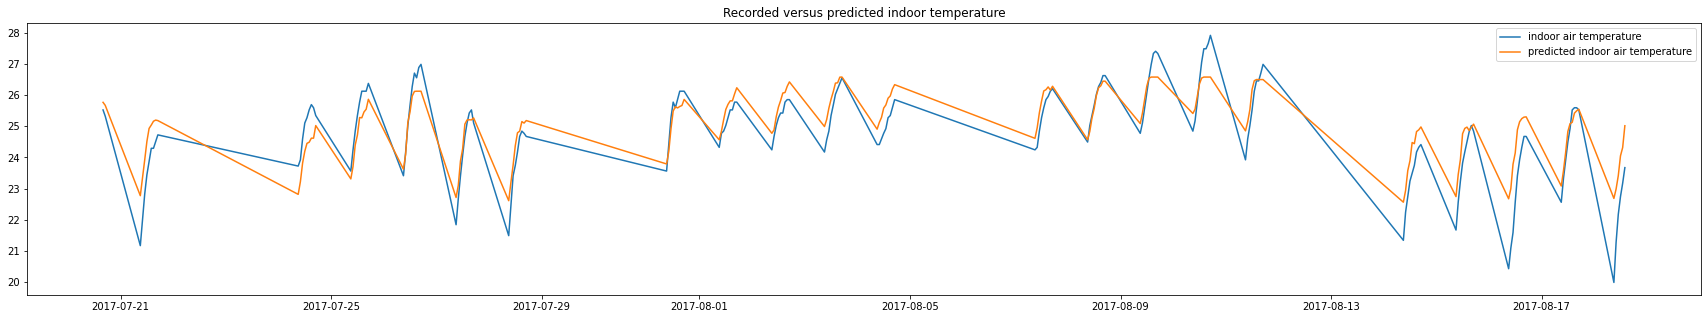

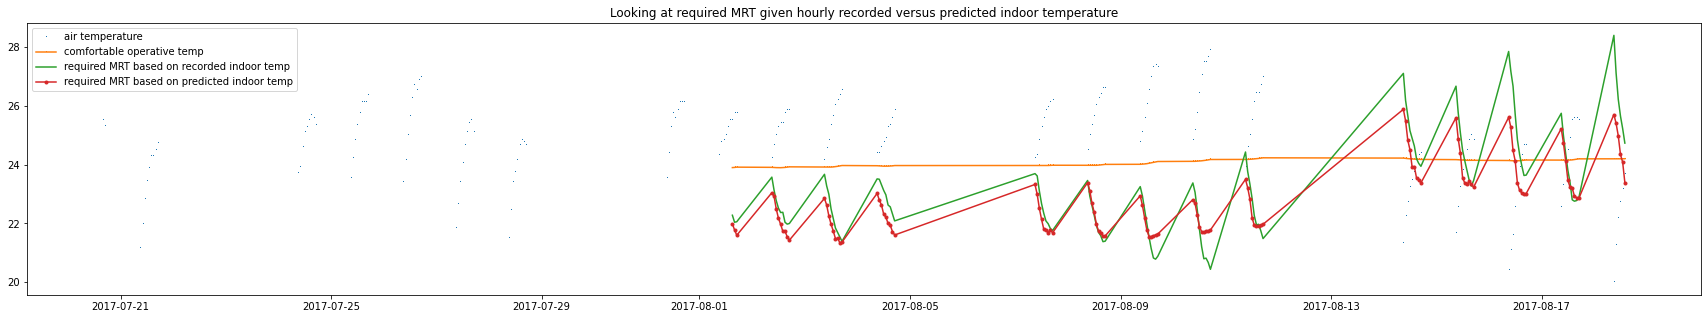

In [49]:
df_plot = df_all_2.copy()

plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="indoor air temperature", linestyle='-', marker='')
plt.plot(x_ax, df_plot.ind_air_predicted, label="predicted indoor air temperature", linestyle='-', marker='')
plt.title("Recorded versus predicted indoor temperature")
plt.legend()
plt.show()


plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="air temperature", linestyle=' ', marker=',')
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker=',')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='-', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show()

## How did the prediction-based MRT perform relative to the known-temp-based MRT? Specifically, we care about the performance during occupied hours... (and peaks along with dewpoint, more than hour-by-hour accuracy).

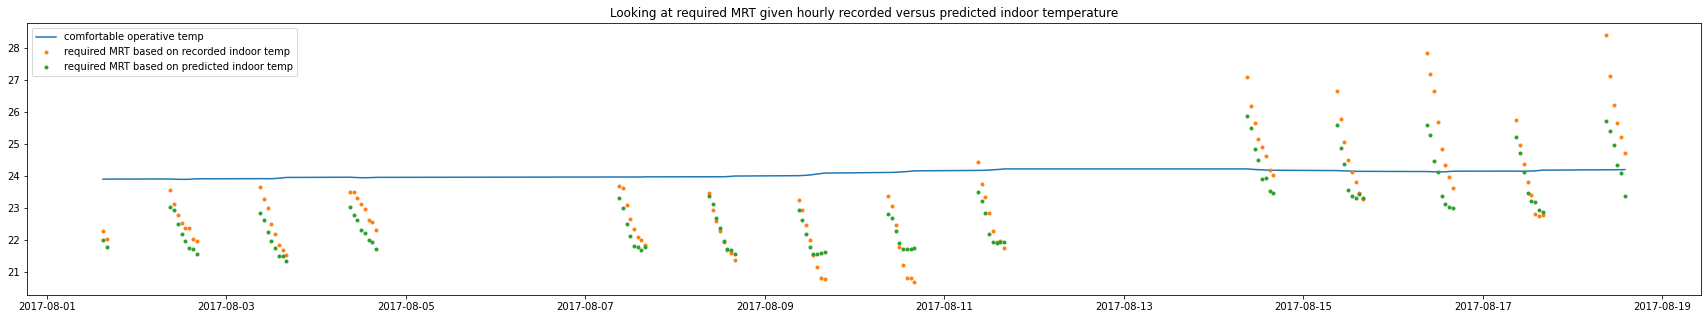

In [50]:
# Compare times of day when occupied to see 'how good' the prediction is...
df_daytime = df_all_2[df_all_2.index.hour.isin(range(9,17))] # Filter by time of day on df_all_2 which holds the results of text x, test y and predicted Y, along with MRT. 

#Visualize occupied hours only
df_plot=df_daytime.copy()
plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='', marker='.')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show()

In [ ]:
# alternative to above plot.. #graphically white-out spans of unoccupied times? 

# see fill bewteen two vertical lines https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
# ax.axvspan(8, 14, alpha=0.5, color='red')

## Quantify degree-hours that exceed comfort threshold, during occupied building hours



In [ ]:
 
# Isolate hours when building is in operation 

# Identify hours when comfy_MRT exceeds 

In [ ]:
# Reconstruct a dataframe to hold: Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 

# this is the MRT, adjusted so it never flips into 'heating' by setting the comfy temp as an MRT 'ceiling' 
cool_enough = df_Y_scratch['op_tmp_comfy']>df_Y_scratch['air_tmp_ind'] 
df_Y_scratch.loc[cool_enough, 'MRT_comfy'] = df_Y_scratch.loc[cool_enough, 'op_tmp_comfy']  # on cool days, set MRT to comfortable operative temp